<a href="https://colab.research.google.com/github/Priyansh-Mandkaria/hough_transform/blob/main/lane_ldws_hough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing the usefull dependencies

In [ ]:
!apt-get -qq update
!apt-get -qq install -y ffmpeg    # for frame extraction
!pip install -q yt-dlp            # this import we used beacuse we can use the youtbe video dash cam video
!pip install pytube

# Mounting Google Drive for persistent storage and to save outputs:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Downloading a YouTube dashcam video

In [ ]:
YOUTUBE_URL="https://www.youtube.com/watch?v=uKHe9_3qRV4"
!yt-dlp -f best -o "/content/road.%(ext)s" "$YOUTUBE_URL"
!ls -lh /content/road.*

         To let yt-dlp download and merge the best available formats, simply do not pass any format selection.
         If you know what you are doing and want only the best pre-merged format, use "-f b" instead to suppress this warning
[youtube] Extracting URL: https://www.youtube.com/watch?v=uKHe9_3qRV4
[youtube] uKHe9_3qRV4: Downloading webpage
[youtube] uKHe9_3qRV4: Downloading tv simply player API JSON
[youtube] uKHe9_3qRV4: Downloading tv client config
[youtube] uKHe9_3qRV4: Downloading player 6742b2b9-main
[youtube] uKHe9_3qRV4: Downloading tv player API JSON
[info] uKHe9_3qRV4: Downloading 1 format(s): 18
[download] Sleeping 3.00 seconds as required by the site...
[download] Destination: /content/road.mp4
[download] 100% of  752.50KiB in 00:00:00 at 3.41MiB/s
-rw-r--r-- 1 root root 753K Aug 30 08:23 /content/road.mp4


In [ ]:
import cv2, os, sys
video_candidates = [p for p in os.listdir('/content') if p.startswith('road.')]
print("Candidates:", video_candidates)
path = "/content/" + video_candidates[0]
cap = cv2.VideoCapture(path)
ret, frame = cap.read()
print("Can read first frame?", ret)
if ret:
    print("Frame shape:", frame.shape)
cap.release()

Candidates: ['road.mp4']
Can read first frame? True
Frame shape: (360, 640, 3)


In [ ]:
!mkdir -p /content/frames
!ffmpeg -y -i /content/road.mp4 -vf fps=10 /content/frames/frame_%06d.jpg
!ls -l /content/frames | head -n 10


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [125]:
%%bash
cat > /content/lane_ldws_hough.py <<'PY'
# <<--- PASTE the entire Python script contents exactly as in your canvas here --->>

import cv2
import numpy as np
import os

input_dir = "/content/frames"
output_dir = "/content/output_frames"
os.makedirs(output_dir, exist_ok=True)

# how much to move the left line towards the right (pixels)
LEFT_SHIFT =  60
RIGHT_SHIFT = -60

def region_of_interest(img):
    height, width = img.shape[:2]
    mask = np.zeros_like(img)

    # ROI trapezoid to cover the road ahead
    polygon = np.array([[
        (int(width*0.2), height),      # bottom-left
        (int(width*0.8), height),      # bottom-right
        (int(width*0.55), int(height*0.55)), # top-right
        (int(width*0.45), int(height*0.55))  # top-left
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)
    return cv2.bitwise_and(img, mask)

def average_slope_intercept(lines, img_shape):
    left_lines, right_lines = [], []
    left_weights, right_weights = [], []
    if lines is None:
        return None, None

    for line in lines:
        x1,y1,x2,y2 = line[0]
        if x2 == x1:
            continue
        slope = (y2-y1)/(x2-x1)
        intercept = y1 - slope*x1
        length = np.sqrt((y2-y1)**2 + (x2-x1)**2)
        if slope < -0.3:   # left line (negative slope)
            left_lines.append((slope, intercept))
            left_weights.append(length)
        elif slope > 0.3:  # right line (positive slope)
            right_lines.append((slope, intercept))
            right_weights.append(length)

    left_lane = make_line_points(np.average(left_lines, axis=0, weights=left_weights), img_shape) if left_lines else None
    right_lane = make_line_points(np.average(right_lines, axis=0, weights=right_weights), img_shape) if right_lines else None
    return left_lane, right_lane

def make_line_points(line, img_shape):
    slope, intercept = line
    y1 = img_shape[0]
    y2 = int(y1*0.6)  # line goes 60% up the frame
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return (x1,y1,x2,y2)

for fname in sorted(os.listdir(input_dir)):
    if not fname.endswith((".jpg",".png")):
        continue

    path = os.path.join(input_dir, fname)
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 50, 150)

    cropped = region_of_interest(edges)

    lines = cv2.HoughLinesP(cropped, 2, np.pi/180, 50,
                            minLineLength=50, maxLineGap=150)

    left_lane, right_lane = average_slope_intercept(lines, img.shape)

    # Shift left line toward middle lane
    if left_lane is not None:
        x1,y1,x2,y2 = left_lane
        x1 += LEFT_SHIFT
        x2 += LEFT_SHIFT
        left_lane = (x1,y1,x2,y2)
        cv2.line(img, (x1,y1), (x2,y2), (0,255,255), 8)  # yellow shifted line

    # Right lane stays the same
    if right_lane is not None:
        x1,y1,x2,y2 = right_lane
        x1 += RIGHT_SHIFT
        x2 += RIGHT_SHIFT
        right_lane = (x1,y1,x2,y2)
        cv2.line(img, (x1,y1), (x2,y2), (0,255,0), 8)  # green shifted line
    # Fill lane area
    if left_lane is not None and right_lane is not None:
        pts = np.array([[(left_lane[0], left_lane[1]), (left_lane[2], left_lane[3]),
                         (right_lane[2], right_lane[3]), (right_lane[0], right_lane[1])]])
        overlay = img.copy()
        cv2.fillPoly(overlay, pts, (0,255,0))
        img = cv2.addWeighted(overlay, 0.3, img, 0.7, 0)

    out_path = os.path.join(output_dir, fname)
    cv2.imwrite(out_path, img)

print("✅ Processing complete! Check /content/output_frames")

PY


In [126]:
!ls -lh /content/lane_ldws_hough.py


-rw-r--r-- 1 root root 3.6K Aug 30 10:30 /content/lane_ldws_hough.py


In [127]:
!python3 /content/lane_ldws_hough.py --images /content/frames --output /content/annotated_frames


✅ Processing complete! Check /content/output_frames


In [128]:
!ls -lh /content/output_frames | head -n 10


total 5.0M
-rw-r--r-- 1 root root 50K Aug 30 10:30 frame_000001.jpg
-rw-r--r-- 1 root root 54K Aug 30 10:30 frame_000002.jpg
-rw-r--r-- 1 root root 59K Aug 30 10:30 frame_000003.jpg
-rw-r--r-- 1 root root 60K Aug 30 10:30 frame_000004.jpg
-rw-r--r-- 1 root root 53K Aug 30 10:30 frame_000005.jpg
-rw-r--r-- 1 root root 49K Aug 30 10:30 frame_000006.jpg
-rw-r--r-- 1 root root 44K Aug 30 10:30 frame_000007.jpg
-rw-r--r-- 1 root root 42K Aug 30 10:30 frame_000008.jpg
-rw-r--r-- 1 root root 38K Aug 30 10:30 frame_000009.jpg


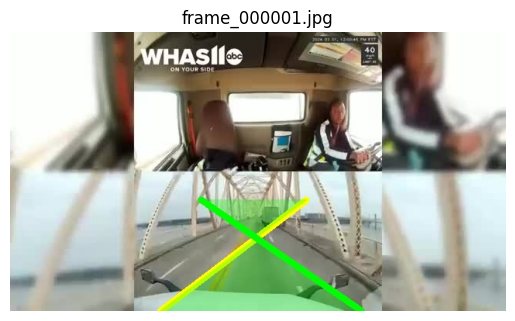

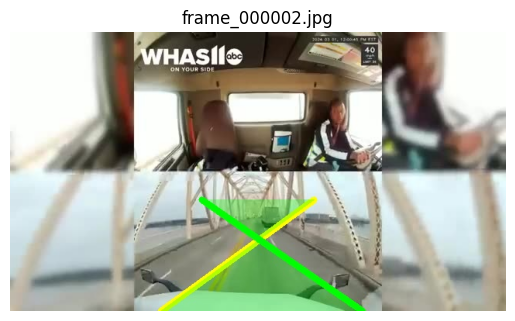

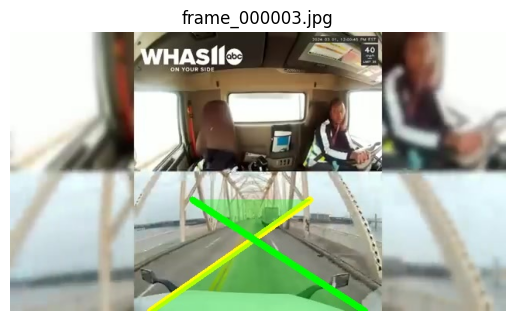

In [129]:
import cv2
import matplotlib.pyplot as plt
import glob

# pick first 3 processed frames
files = sorted(glob.glob("/content/output_frames/*.jpg"))[:3]

for f in files:
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert for matplotlib
    plt.imshow(img)
    plt.title(f.split("/")[-1])
    plt.axis("off")
    plt.show()


In [130]:
from IPython.display import Video, display
display(Video('/content/processed.mp4', embed=True, width=800))


In [131]:
 from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread('/content/lane_ldws_hough.py'.replace('lane_ldws_hough.py','processed_frames/frame_000010.jpg'))  # EDIT path if different
# Or list output frames to pick one:
!ls -l /content | head -n 20
# Use the correct frame path then:
# img = cv2.imread('/content/processed_frames/frame_000010.jpg')
if img is not None:
    cv2_imshow(img)
else:
    print("Change the frame path to a valid annotated frame file.")


total 1600
drwx------ 5 root root   4096 Aug 30 08:14 drive
drwxr-xr-x 2 root root   4096 Aug 30 08:30 frames
-rw-r--r-- 1 root root   3606 Aug 30 10:30 lane_ldws_hough.py
drwxr-xr-x 2 root root   4096 Aug 30 08:38 output_frames
-rw-r--r-- 1 root root 840061 Aug 30 09:12 processed.mp4
-rw-r--r-- 1 root root 770558 Aug 30 08:23 road.mp4
drwxr-xr-x 1 root root   4096 Aug 28 13:43 sample_data
Change the frame path to a valid annotated frame file.


In [132]:
!ls -lh /content/processed.mp4


-rw-r--r-- 1 root root 821K Aug 30 09:12 /content/processed.mp4


In [134]:
!ffmpeg -framerate 20 -i /content/output_frames/frame_%06d.jpg -c:v libx264 -pix_fmt yuv420p /content/processed.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [135]:
from IPython.display import Video, display
display(Video('/content/processed.mp4', embed=True, width=800))


In [ ]:
!ls -lh /content | sed -n '1,200p'

total 776K
drwx------ 5 root root 4.0K Aug 30 08:14 drive
drwxr-xr-x 2 root root 4.0K Aug 30 08:30 frames
-rw-r--r-- 1 root root 1.6K Aug 30 09:05 lane_ldws_hough.py
drwxr-xr-x 2 root root 4.0K Aug 30 08:38 output_frames
-rw-r--r-- 1 root root 753K Aug 30 08:23 road.mp4
drwxr-xr-x 1 root root 4.0K Aug 28 13:43 sample_data


In [ ]:
# example destination directory on Drive
!mkdir -p /content/drive/MyDrive/lane_project_output
!cp /content/processed.mp4 /content/drive/MyDrive/lane_project/
# if frames:
!cp -r /content/processed_frames /content/drive/MyDrive/lane_project/


cp: cannot stat '/content/processed.mp4': No such file or directory
cp: cannot stat '/content/processed_frames': No such file or directory
